#**Project  : Plant Pathology 2021 - FGVC8**

**Realised by :** Arij BOUGDA & Chayma BELGAIED 

**M2 IASD**


##**Business understanding:**




**Introduction and Challenge**


---
Apples are one of the most important temperate fruit crops in the world. Foliar (leaf) diseases pose a major threat to the overall productivity and quality of apple orchards. The current process for disease diagnosis in apple orchards is based on manual scouting by humans, which is time-consuming and expensive.

Although computer vision-based models have shown promise for plant disease identification, there are some limitations that need to be addressed. Large variations in visual symptoms of a single disease across different apple cultivars, or new varieties that originated under cultivation, are major challenges for computer vision-based disease identification. These variations arise from differences in natural and image capturing environments, for example, leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging etc.

**Specific Objectives**

---



The main objective of the project is to develop machine learning-based models to accurately classify a given leaf image from the test dataset to a particular disease category, and to identify an individual disease from multiple disease symptoms on a single leaf image.






**Here what we'll do in this kernel:**

1.   Loading & Looking at the data 
2.   Data Preprocessing
3.   Visualization
3.   Modeling
4.   Transfer Learning without data augmentation
5.   Transfer Learning with data augmentation





**Import packages**

In [ ]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import cv2
import os # used for navigating to image path
from os import walk
import pandas as pd
import PIL
from PIL import Image # used for loading images
import numpy as np
import pylab
from collections import Counter
import shutil
import itertools

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
drive

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.5.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


##**Data understanding:**

#### **Dataset Description**
The dataset contains **17989** high-quality RGB images of apple foliar diseases, including a large expert-annotated disease dataset. This dataset reflects real field scenarios by representing non-homogeneous backgrounds of leaf images taken at different maturity stages and at different times of day under different focal camera settings.

#### **Loading zip repository from Drive**
the zip file contains:

*   **train_images** : contain all images.
*   **labels** : csv file

 

In [ ]:
# List .txt files in the root.
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
listed = drive.ListFile({'q': "title contains 'zip'"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

title Projet_Dauphine_2021-20210519T115027Z-001.zip, id 1xt0vghQZHcY0gFPEWMAWV9pzzWrI-YHj
title BreakThrough-Chess-an-AlphaZero-Implementation--master.zip, id 1mVfqgB9C9rqDYXTXdkGpbLgvy3S41TRR


In [ ]:
# Get File from Drive using file-ID
downloaded = drive.CreateFile({'id':'1xt0vghQZHcY0gFPEWMAWV9pzzWrI-YHj'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Projet_Dauphine_2021.zip')

In [ ]:
# unzip the file 
!unzip /content/Projet_Dauphine_2021.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Projet_Dauphine_2021/train_images/Compressed_845d964d9f69b149.jpg  
  inflating: Projet_Dauphine_2021/train_images/Compressed_c1ca6b789e0cdb34.jpg  
  inflating: Projet_Dauphine_2021/train_images/Compressed_e004d1da9e915f9b.jpg  
  inflating: Projet_Dauphine_2021/train_images/Compressed_b247ccfc06bfe808.jpg  
  inflating: Projet_Dauphine_2021/train_images/Compressed_a8eed2c0cbcb3c0e.jpg  
  inflating: Projet_Dauphine_2021/train_images/Compressed_bf3e81021c99e2f3.jpg  
  inflating: Projet_Dauphine_2021/train_images/Compressed_baebf0f58010cd93.jpg  
  inflating: Projet_Dauphine_2021/train_images/Compressed_eff18c3836c55483.jpg  
  inflating: Projet_Dauphine_2021/train_images/Compressed_aeac803cddc22a9f.jpg  
  inflating: Projet_Dauphine_2021/train_images/Compressed_e1a1ba0bda4fdc90.jpg  
  inflating: Projet_Dauphine_2021/train_images/Compressed_9d7c78a7308f30ac.jpg  
  inflating: Projet_Dauphine_20

In [ ]:
# remove the zip file
!rm /content/Projet_Dauphine_2021.zip

#### **Loading file labels.csv**




The file labels.csv contains the training set metadata.



*   **Column image** :
 the image ID.
*   **Column labels** :  the target classes, a space delimited list of all diseases found in the image. 

In [ ]:
# Read file as panda dataframe
df = pd.read_csv('/content/Projet_Dauphine_2021/labels.csv') 

In [ ]:
# head
df.head(10)

,image,labels
0,Compressed_800113bb65efe69e.jpg,healthy
1,Compressed_8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,Compressed_80070f7fb5e2ccaa.jpg,scab
3,Compressed_80077517781fb94f.jpg,scab
4,Compressed_800cbf0ff87721f8.jpg,complex
5,Compressed_800edef467d27c15.jpg,healthy
6,Compressed_800f85dc5f407aef.jpg,rust
7,Compressed_801d6dcd96e48ebc.jpg,healthy
8,Compressed_801f78399a44e7af.jpg,complex
9,Compressed_8021b94d437eb7d3.jpg,healthy


In [ ]:
# tail
df.tail(10)

,image,labels
18622,Compressed_fff5d8c2801ec40e.jpg,healthy
18623,Compressed_fff8e3b8c1d88300.jpg,healthy
18624,Compressed_fff9c005c2c738c2.jpg,healthy
18625,Compressed_fffaa4a0fe416808.jpg,scab
18626,Compressed_fffb65761200b054.jpg,healthy
18627,Compressed_fffb900a92289a33.jpg,healthy
18628,Compressed_fffc488fa4c0e80c.jpg,scab
18629,Compressed_fffc94e092a59086.jpg,rust
18630,Compressed_fffe105cf6808292.jpg,scab frog_eye_leaf_spot
18631,Compressed_fffe472a0001bd25.jpg,healthy


In [ ]:
# length of the csv file
len(df)

18632

In [ ]:
# description of image_column
df["image"].describe()

count                               18632
unique                              18632
top       Compressed_999dc998e68d1bc8.jpg
freq                                    1
Name: image, dtype: object

In [ ]:
# description of labels_column
df["labels"].describe()

count     18632
unique       12
top        scab
freq       4826
Name: labels, dtype: object

In [ ]:
# Display the category_list
category_number = len(df['labels'].unique())
category=df['labels'].unique()
print("category_number" , category_number)
print("category_list : " , category)

category_number 12
category_list :  ['healthy' 'scab frog_eye_leaf_spot complex' 'scab' 'complex' 'rust'
 'frog_eye_leaf_spot' 'powdery_mildew' 'scab frog_eye_leaf_spot'
 'frog_eye_leaf_spot complex' 'rust frog_eye_leaf_spot'
 'powdery_mildew complex' 'rust complex']


In [ ]:
# Function to display the number of images for each category
data=df['labels'].value_counts()

In [ ]:
# Display the number of images for each category
data

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

##**Data Preprocessing**




**Purpose of the function set_values( ) :** 


Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.
So, we are going to classify the complex class and the subset of the diseases identified in one class named : **multiple_diseases**.

In [ ]:
# the function below will reclassify our images. 
# the purpose of the dictionary is to reclassify the labels into four classes.

def set_values(row, value):
    return value[row]
 
map_dictionary ={'healthy' : 'healthy' , 
                 "scab frog_eye_leaf_spot complex" : "multiple_diseases" ,
                 'scab' : 'scab',
                 "complex" : "multiple_diseases", 
                 'rust':'rust',
                 "frog_eye_leaf_spot" : "multiple_diseases", 
                 "powdery_mildew" : "multiple_diseases", 
                 "scab frog_eye_leaf_spot" : "multiple_diseases", 
                 "frog_eye_leaf_spot complex" : "multiple_diseases",
                 "rust frog_eye_leaf_spot":"multiple_diseases",
                 "rust frog_eye_leaf_spot":"multiple_diseases",
                 "powdery_mildew complex":"multiple_diseases",
                 "rust complex":"multiple_diseases"} 

# Creation of a column named "new_labels" that containing the new labels classification. 
df['new_labels'] = df['labels'].apply(set_values, args =(map_dictionary, ))
df.head(10)

,image,labels,new_labels
0,Compressed_800113bb65efe69e.jpg,healthy,healthy
1,Compressed_8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,multiple_diseases
2,Compressed_80070f7fb5e2ccaa.jpg,scab,scab
3,Compressed_80077517781fb94f.jpg,scab,scab
4,Compressed_800cbf0ff87721f8.jpg,complex,multiple_diseases
5,Compressed_800edef467d27c15.jpg,healthy,healthy
6,Compressed_800f85dc5f407aef.jpg,rust,rust
7,Compressed_801d6dcd96e48ebc.jpg,healthy,healthy
8,Compressed_801f78399a44e7af.jpg,complex,multiple_diseases
9,Compressed_8021b94d437eb7d3.jpg,healthy,healthy


In our directory, we have several images, each image has an identifier "id" and label.

We map each image path with its id, then we build a list named "data" contain:
**image _id** and **labels**.

In [ ]:
# import train_images
_, _, filenames = next(walk("/content/Projet_Dauphine_2021/train_images"))

In [ ]:
data =[]
for index, row in df.iterrows():
  if row['image'] in filenames: 
    data.append((row['image'], row['new_labels']))

In [ ]:
# Display the data list.
data

[('Compressed_8002cb321f8bfcdf.jpg', 'multiple_diseases'),
 ('Compressed_80070f7fb5e2ccaa.jpg', 'scab'),
 ('Compressed_80077517781fb94f.jpg', 'scab'),
 ('Compressed_800cbf0ff87721f8.jpg', 'multiple_diseases'),
 ('Compressed_800edef467d27c15.jpg', 'healthy'),
 ('Compressed_800f85dc5f407aef.jpg', 'rust'),
 ('Compressed_801d6dcd96e48ebc.jpg', 'healthy'),
 ('Compressed_801f78399a44e7af.jpg', 'multiple_diseases'),
 ('Compressed_8021b94d437eb7d3.jpg', 'healthy'),
 ('Compressed_802291cee9fec9f4.jpg', 'multiple_diseases'),
 ('Compressed_80230a9a3f7a9f6b.jpg', 'scab'),
 ('Compressed_8023c3f31f875b6c.jpg', 'healthy'),
 ('Compressed_80261f473eafb92c.jpg', 'scab'),
 ('Compressed_80273091d9e9bddb.jpg', 'multiple_diseases'),
 ('Compressed_802962dc3ecdbb8d.jpg', 'scab'),
 ('Compressed_802969daaddbbc8c.jpg', 'scab'),
 ('Compressed_802b34badefa2ed0.jpg', 'scab'),
 ('Compressed_802b59956a7aa5e7.jpg', 'healthy'),
 ('Compressed_802f4bbd295063fe.jpg', 'scab'),
 ('Compressed_802f7439ec1ef0cd.jpg', 'multiple

##**Visualization**

The first step is to visualize and examine the data.
the objective of this section is to understand better the problem that we have to handle.





####**Visualize Images**

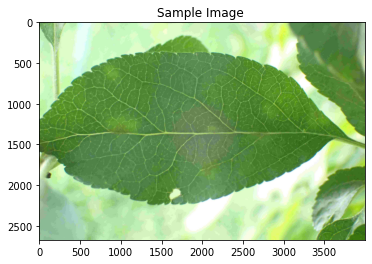

In [ ]:
# Display an image from our dataset
plt.imshow(mpimg.imread('/content/Projet_Dauphine_2021/train_images/Compressed_f47ad2a2ca934d8a.jpg'))
plt.title("Sample Image ")
plt.show()

**Class Identification**      
In order to see which properties each class has, we will take one image of each class and print them, in order to draw conclusion.    
The images are shown below :  

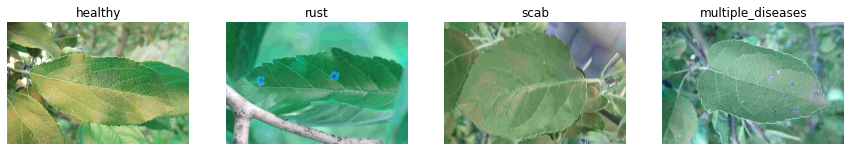

In [ ]:
# Function to display image of each class.
def display_images():
  # Figure size 
  plt.figure(figsize=(15, 8))

  # Path of images 
  liste_path= ['/content/Projet_Dauphine_2021/train_images/Compressed_8021b94d437eb7d3.jpg',
  '/content/Projet_Dauphine_2021/train_images/Compressed_800f85dc5f407aef.jpg',
  '/content/Projet_Dauphine_2021/train_images/Compressed_802969daaddbbc8c.jpg',
  '/content/Projet_Dauphine_2021/train_images/Compressed_801f78399a44e7af.jpg']
  
  name=["healthy","rust","scab","multiple_diseases"]
      
  for i in range(4):
      plt.subplot(1, 4, i + 1)
      cv2.imread((liste_path[i]))
      # Showing images
      plt.imshow(cv2.imread((liste_path[i])))
      plt.axis('off')
      plt.title(name[i])
      
  plt.show()
display_images()

**Interpretation :** 


As it can be observed the rust , scab , multiple diseases , have some kind of stain or are eaten by something .In order th know more about the problem at hand .further research has been done about those diseases , which are caused by fungi 
-the most obvious of Scab occur on leaves and fruit in the spring and summer , and look like very small valvety brown to olive-green spots that enlarge and draken to become more or less circular .rust can be identified early on by white , slightly raised spots on the undersides of leaves and on the stems . After a short period of time ,there spots become covered with reddish-orange spore masses . Later , leaf pustules mayvturn yellow-green and eventually black.Severe infestations will deform and yellow leaves and causes leaf drop .As it can be observed rust has many stages, and each of them is different both in color and in mag6, so it can be different to identify it.
The multiple diseases class in this dataset corresponds to plants that have rust and scab and possibly more diseases.  Therefore those plants will have the properties of both rust ans scab class.

####**Visualize categories**

As it has been previously mentioned, there are 4 classes, but those 4 classes don't have the same representation. The data is unbalanced, and its distribution can be seen in the figure below.

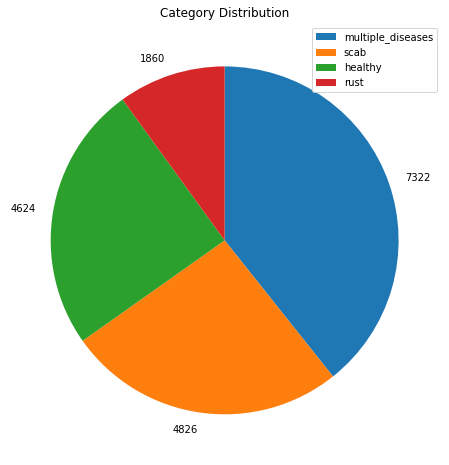

In [ ]:
# plt API
fig = plt.figure(figsize=( 8, 8))
ax = fig.subplots(1,1)

data = df['new_labels'].value_counts()
labels=[data[x] for x in data.index]
legend = [x for x in data.index]

# Using pie() to display a Pie chart 
ax.pie(data, labels=labels, startangle=90, counterclock=False)
# Add the legend
ax.legend((legend))
# Add the set title 
ax.set_title("Category Distribution")
plt.show()

**Interpretation :** 


From the 4 classes,**"multiple_diseases"** represent the highest category,  also **"scab"** and **"healthy"** are more or less equal representation but the **"rust"** class has a much lower representation.

####**Image size distribution**

In [ ]:
# Get image size
image = PIL.Image.open("/content/Projet_Dauphine_2021/train_images/Compressed_801f78399a44e7af.jpg")
width, height =image.size  
print(width, height)

4000 2672


In order to visualize the sizes of our images, we have created two lists :
*   The first named **"width_l"** which contains the widths of all images.
*   The second named **"height_l"** contains the lengths of all images.

In [ ]:
# Initialize the image list
image_list=[]
for index, row in df.iterrows():
  if row['image'] in filenames: 
    # Fill image_list  
    image_list.append((row['image']))   

width_l=[]  
height_l=[]  
path="/content/Projet_Dauphine_2021/train_images/"
for x in image_list:
  image = PIL.Image.open(path+"/"+x)
  width, height = image.size 
  # Fill width_l list
  width_l.append(width)
  # Fill height_l list
  height_l.append(height)

#####**Distribution of images according to their widths**

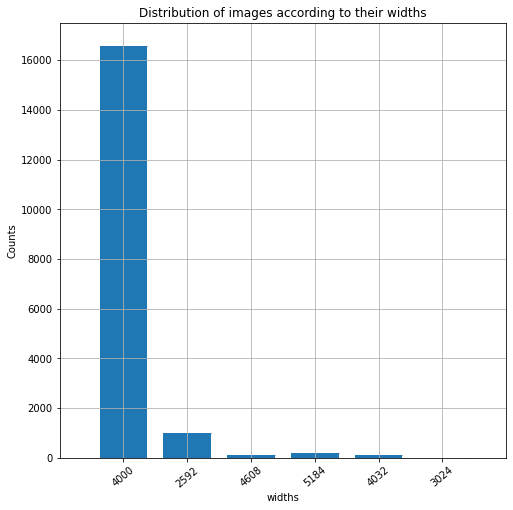

In [ ]:
# Figure size
fig = plt.figure(figsize=(8, 8))

# Configure and draw the histogram figure
x = [1,2,3,4,5,6]
# List of abscissas
height = list(Counter(width_l).values())
# Bar thickness
width = 0.75
BarName =  list(Counter(width_l).keys())

# Make a bar plot
plt.bar(x, height, width)
plt.scatter([i+width/2.0 for i in x],height,color='k',s=0.01)
# Set the xlim to 7, 0
plt.xlim(0,7)
# Set the ylim to 0,17500
plt.ylim(0,17500)
plt.grid() #Configure the grid lines
# Set the label for the y-axis.
plt.ylabel('Counts')
# Set the label for the x-axis.
plt.xlabel("widths")
# Add the title
plt.title('Distribution of images according to their widths')

pylab.xticks(x, BarName, rotation=40)
# Display the image
plt.show()

**Interpretation :**


After plotting  histogram of **Distribution of images according to their widths**,  we have :

*   4000 images with width 16550
*   2592 images with width 997
*   4608 images with width 120
*   4032 images with width 187
*   3024 images with width 6



we notice that the most frequent width of the images is 4000 pixels , So we can conclude that to find a good model, we have to resize the widths of our images to 4000 pixels.


#####**Distribution of images according to their heights**

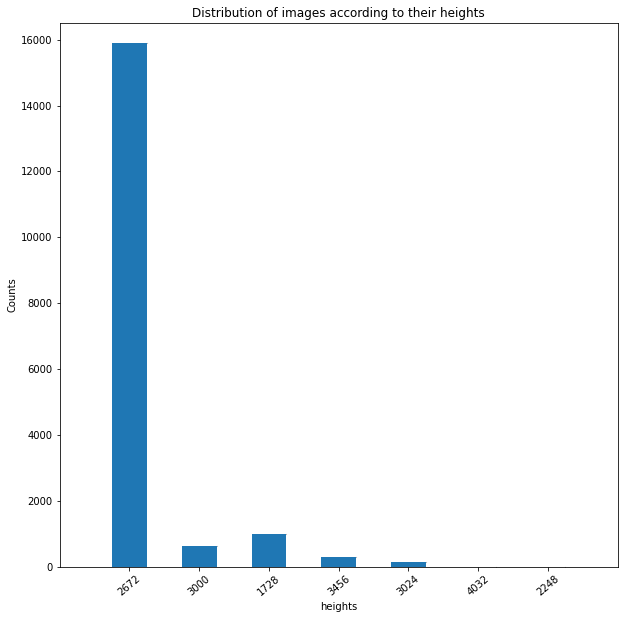

In [ ]:
# Figure size
fig = plt.figure(figsize=(10, 10))

# Configure and draw the histogram figure

x = [1,2,3,4,5,6,7]
# List of abscissas
height = list(Counter(height_l).values())
# Bar thickness
width = 0.5
BarName = list(Counter(height_l).keys()) 

# Make a bar plot
plt.bar(x, height, width)
plt.scatter([i+width/2.0 for i in x],height,color='k',s=0.01)
# Set the ylim to 0, 8
plt.xlim(0,8)
# Set the ylim to 0, 16500
plt.ylim(0,16500)
# Set the label for the y-axis.
plt.ylabel('Counts')
# Set the label for the x-axis.
plt.xlabel("heights")
# Add the title
plt.title('Distribution of images according to their heights')

pylab.xticks(x, BarName, rotation=40)
# Display the image
plt.show()

**Interpretation :**

After plotting  histogram of **Distribution of images according to their heights**, we have :

*   15907 images with height 2672
*   642 images with height 3000
*   997 images with height 1728
*   307 images with height 3456
*   3 images with height 3024
*   1 images with height 4032



we notice that the most frequent height of the images is 2672 pixels , So we can conclude that to find a good model, we must resize the height of our images to 2672 pixels. 



**After plotting the size distribution histograms, we can conclude that the ideal size to resize the images is 4000 * 2672**

##**Modeling:**

In [ ]:
# we will create folders, each folder will contains the correspond class images.

# Create train_image_new folder
path_train_image="/content/Projet_Dauphine_2021/train_image_new"
os.mkdir(path_train_image)

# define the name of the directory to be created
path_healthy = "/content/Projet_Dauphine_2021/train_image_new/healthy"
os.mkdir(path_healthy)

# Directory with for our training rust pictures
path_rust = "/content/Projet_Dauphine_2021/train_image_new/rust"
os.mkdir(path_rust)

# Directory with for our training scab pictures
path_scab = "/content/Projet_Dauphine_2021/train_image_new/scab"
os.mkdir(path_scab)

# Directory with for our training multiple_diseases pictures
path_multiple_diseases = "/content/Projet_Dauphine_2021/train_image_new/multiple_diseases"
os.mkdir(path_multiple_diseases)

In [ ]:
data =[]
for index, row in df.iterrows():
  if row['image'] in filenames: 
    data.append((row['image'], row['new_labels']))

In [ ]:
# Fill the folders with correspond images. 
# Using shutil.copy: Utility functions for copying and archiving files and directory trees.

for img , ty in data:
  if ty=='healthy':
    shutil.copy("/content/Projet_Dauphine_2021/train_images/"+img, "/content/Projet_Dauphine_2021/train_image_new/healthy")
  if ty=='rust':
    shutil.copy("/content/Projet_Dauphine_2021/train_images/"+img, "/content/Projet_Dauphine_2021/train_image_new/rust")
  if ty=='scab':
    shutil.copy("/content/Projet_Dauphine_2021/train_images/"+img, "/content/Projet_Dauphine_2021/train_image_new/scab")
  if ty=='multiple_diseases':
    shutil.copy("/content/Projet_Dauphine_2021/train_images/"+img, "/content/Projet_Dauphine_2021/train_image_new/multiple_diseases")

### **Select the module to use**


The transfer learning  is able to detect patterns in the image (diseases in our case).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.


In this notebook , we choose **Mobilenet_v2_130_224** 

Our **Mobilenet_v2_130_224** model takes as input size: **224 × 224 pixels**.

In [ ]:
model_name = "mobilenet_v2_130_224" # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 #@param {type:"integer"}

Selected model: mobilenet_v2_130_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4
Input size (224, 224)


###**Transfer learning without data augmentation**

In [ ]:
data_dir= '/content/Projet_Dauphine_2021/train_image_new'
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")


valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 3596 images belonging to 4 classes.
Found 14393 images belonging to 4 classes.


We have 18632 labeled images including 643 labeled images which are not taken into account in the 4 classes.

In our dataset we have 17989 images, to train our model, we put **20 %** for the validation (3596 images) and **80 %**  for training ( 14393 images ).

In [ ]:
# Defining model
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1664)              3766048   
_________________________________________________________________
dropout (Dropout)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 6660      
Total params: 3,772,708
Trainable params: 3,728,452
Non-trainable params: 44,256
_________________________________________________________________


In [ ]:
# Compile the model (we used SGD optimizer and we choose a  Categorical crossentropy and metric accuracy)
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
# Fit the model 
hist = model.fit(
    train_generator,
    epochs=4, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/4
449/449 [==============================] - 2329s 5s/step - loss: 0.7140 - accuracy: 0.8722 - val_loss: 0.5914 - val_accuracy: 0.9300
Epoch 2/4
449/449 [==============================] - 2242s 5s/step - loss: 0.5544 - accuracy: 0.9492 - val_loss: 0.5751 - val_accuracy: 0.9411
Epoch 3/4
449/449 [==============================] - 2241s 5s/step - loss: 0.5075 - accuracy: 0.9724 - val_loss: 0.5808 - val_accuracy: 0.9358
Epoch 4/4
449/449 [==============================] - 2246s 5s/step - loss: 0.4816 - accuracy: 0.9844 - val_loss: 0.5627 - val_accuracy: 0.9414


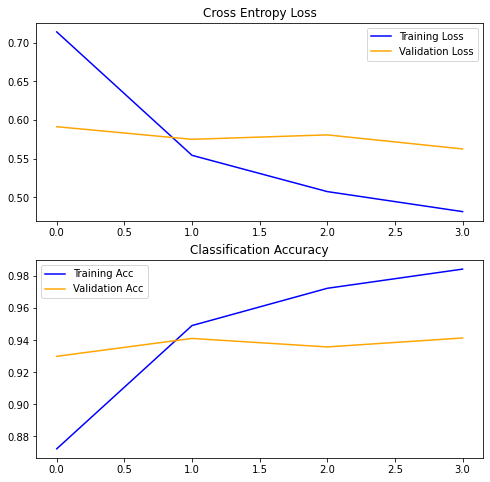

In [ ]:
# Display the loss and metric curves  
def accuracy_lost_curves(history):
  fig = plt.figure(figsize=(8,8))
  
  # plot loss
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(hist['loss'], color='blue', label='train')
  ax1.plot(hist['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])

	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(hist['accuracy'], color='blue', label='train')
  ax2.plot(hist['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
# Learning curves
accuracy_lost_curves(hist)

***Interpretation***:


From the figure above we can see that there is a remarkable gap between the two curves of precision and loss (train and valdiation), we arrive at 94% for the precision and 54% for the loss  , therefore the pre-trained model  **Mobilenet_v2_130_224** does not manage to generalize well, it seems that there is **overfitting**. 


In order to overcome this problem there are several strategies which, in my opinion, would be the most effective to improve this precision score and decrease the loss such as **Data Augmentation**

Try out the model on an image from the validation data:

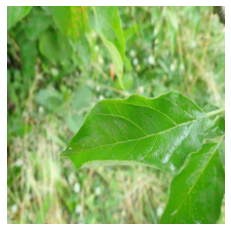

True label: healthy
Predicted label: healthy


In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

###**Transfer learning with data augmentation**

In order to augment the number of images the we have in the training set  we will create synthetic images. We wil apply the following techniques to the original images: 



*   Rotation : we will rotate the images up to 40 degrees
*   Shift: we will shift the images up to 20 %
*   Flip : we will flip the images both horizontally and vertically


 
 


In [ ]:

data_dir= '/content/Projet_Dauphine_2021/train_image_new'
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")


valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 3596 images belonging to 4 classes.
Found 14393 images belonging to 4 classes.


We have  18632 labled images including 643 labled images which aren't much taking into account that we have 4 classes.

In our dataset we have 17989 images, to train our model, we put **20 %** for the validation (3596 images) and **80 %**  for training ( 14393 images ).

In [ ]:
# Defining model
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1664)              3766048   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 6660      
Total params: 3,772,708
Trainable params: 3,728,452
Non-trainable params: 44,256
_________________________________________________________________


In [ ]:
# Compile the model (we used SGD optimizer and we choose a  Categorical crossentropy and metric accuracy)
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
# Fit the model
hist = model.fit(
    train_generator,
    epochs=4, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/4
449/449 [==============================] - 2454s 5s/step - loss: 0.7002 - accuracy: 0.8772 - val_loss: 0.6171 - val_accuracy: 0.9227
Epoch 2/4
449/449 [==============================] - 2435s 5s/step - loss: 0.6087 - accuracy: 0.9205 - val_loss: 0.6554 - val_accuracy: 0.9113
Epoch 3/4
449/449 [==============================] - 2424s 5s/step - loss: 0.5776 - accuracy: 0.9357 - val_loss: 0.5738 - val_accuracy: 0.9406
Epoch 4/4
449/449 [==============================] - 2413s 5s/step - loss: 0.5554 - accuracy: 0.9430 - val_loss: 0.5889 - val_accuracy: 0.9311


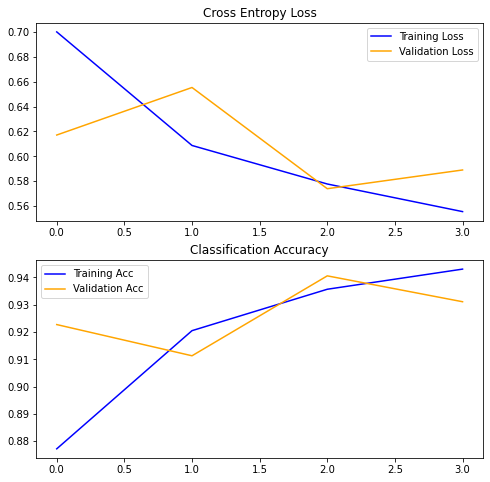

In [ ]:
# Display the loss and metric curves  
def accuracy_lost_curves(history):
  fig = plt.figure(figsize=(8,8))

  # plot loss
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history['loss'], color='blue', label='train')
  ax1.plot(history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
  
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history['accuracy'], color='blue', label='train')
  ax2.plot(history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
# Learning curves
accuracy_lost_curves(hist)

***Interpretation***:


From the figure above, we can see that there is a gap between the two curves of precision and loss (train and valdiation), we arrive at 93% for the precision and 55% for the loss.

Compared to the model without data augmentation, there is gap reduction between the two curves of precision and loss (train and valdiation).
therefore, we can conclude that the overfitting problem persists even with data augmentation. 

So the data augmentation strategy that we have proposed to improve our model and reduce the loss, has no influence.
This is explained by the fact of increasing the database when our database is already huge (contains 17989 images).

In order to overcome this problem, we can propose as a solution to do the "model tuning".

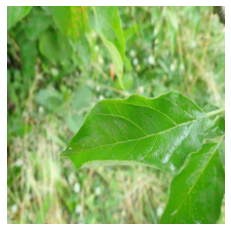

True label: healthy
Predicted label: healthy


In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))